In [1]:
import os
from glob import glob      # This is used for "wildcard" searches of folders.

from astropy.table import Table

from desispec.io import read_spectra
from desispec.spectra import stack as specstack

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math
import statistics

import sys




In [2]:
redux = 'daily/tiles/cumulative'
basedir = os.environ['DESI_SPECTRO_REDUX']

tiles = ['80980', '80981']
tiledate = '20210708'

spectra = None
for tile in tiles:
    tilefolder = '{}/{}/{}/{}'.format(basedir, redux, tile, tiledate)
    coadds = sorted(glob('{}/coadd*.fits'.format(tilefolder)))
    for coadd in coadds:
        spec = read_spectra(coadd)
        zbest_files = coadd.replace('coadd', 'zbest')
        zbest = Table.read(zbest_files, 'ZBEST')
        spec.extra_catalog = zbest

        # Accumulate spectra from all petals into one object, "spectra."
        if spectra is None:
            spectra = spec
        else:
            spectra = specstack([spectra, spec])
            
zbest = spectra.extra_catalog


INFO:spectra.py:282:read_spectra: iotime 0.920 sec to read coadd-0-80980-thru20210708.fits at 2021-07-30T00:40:33.348030
INFO:spectra.py:282:read_spectra: iotime 0.933 sec to read coadd-1-80980-thru20210708.fits at 2021-07-30T00:40:34.717651
INFO:spectra.py:282:read_spectra: iotime 0.917 sec to read coadd-2-80980-thru20210708.fits at 2021-07-30T00:40:37.395407
INFO:spectra.py:282:read_spectra: iotime 0.861 sec to read coadd-3-80980-thru20210708.fits at 2021-07-30T00:40:40.807078
INFO:spectra.py:282:read_spectra: iotime 0.865 sec to read coadd-4-80980-thru20210708.fits at 2021-07-30T00:40:44.902841
INFO:spectra.py:282:read_spectra: iotime 0.838 sec to read coadd-5-80980-thru20210708.fits at 2021-07-30T00:40:49.510940
INFO:spectra.py:282:read_spectra: iotime 0.778 sec to read coadd-6-80980-thru20210708.fits at 2021-07-30T00:40:54.884227
INFO:spectra.py:282:read_spectra: iotime 0.826 sec to read coadd-7-80980-thru20210708.fits at 2021-07-30T00:41:01.119091
INFO:spectra.py:282:read_spectra

In [3]:
select = (zbest['DELTACHI2']>25) & (zbest['ZWARN']==0) & (zbest['Z']<=0.75)

In [10]:
# Defining the most important parts of the peak finder algorithm.

def gauss2(x, b, a, x0, sigma):
        return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
def sub_list_into_max(list,flux):
    maximum = 0
    max_index = 0
    for k in range(len(list)):
        if flux[list[k]] > maximum:
            maximum = flux[list[k]]
            max_index = k
    return max_index
def has_peak_in_range(wave,flux,prom,wid,minwave,maxwave): # rest wavelength in angstroms, arbitrary flux
    good_peaks = []
    good_widths = []
    peaks, widths = scipy.signal.find_peaks(flux, prominence = prom, width = wid)
    widths = widths["widths"]
    best_peak = None
    best_width = 0
    if len(peaks) != 0:
        for k in range(len(peaks)):
            if (minwave <= wave[peaks[k]]):
                if (wave[peaks[k]] <= maxwave):
                    good_peaks.append(peaks[k])
                    good_widths.append(widths[k])
        if good_peaks == []:
            return best_peak, best_width
        max_index = sub_list_into_max(good_peaks,flux)
        best_peak = good_peaks[max_index]
        best_width = good_widths[max_index]
        return best_peak, best_width
    else:
        return best_peak, best_width
    
def snip_data_near_peak(wave,flux,good_peak,good_width):
    peak_edge = math.floor(2.2*(good_width))
    try:
        snipped_wave = wave[good_peak-peak_edge:good_peak+peak_edge]
        snipped_flux = flux[good_peak-peak_edge:good_peak+peak_edge]
    except:
        if (good_peak - peak_edge) < 0:
            snipped_wave = wave[0:good_peak+peak_edge]
            snipped_flux = flux[0:good_peak+peak_edge]
        else:
            snipped_wave = wave[good_peak - peak_edge:len(wave)-1]
            snipped_flux = flux[good_peak - peak_edge:len(wave)-1]
    return snipped_wave,snipped_flux

def fit_gaussian_to_peak(wave,flux,good_peak,good_width):
    
    snipped_wave, snipped_flux = snip_data_near_peak(wave,flux,good_peak,good_width)
    params, _ = curve_fit(gauss2, snipped_wave, snipped_flux,p0=[prom,max(snipped_flux),wave[good_peak],wid])
    return params #xrange, offset, height, average, width

def is_TDE(he_params,o_params,h_params):
    if he_params == []:
        return False
    elif h_params == []:
        return False
    line_ratio = he_params[1]/h_params[1]
    o_ratio = o_params[1]/h_params[1]
    if line_ratio == []:
        return False
    if line_ratio >= 0.9:
        print(line_ratio)
        if o_ratio <= 0.1:
            return True
        elif o_params == []:
            return True
        return False
    return False

# Test to see if the code works for DESI data

In [11]:
total = sum(select)
prom  = 0
wid = 0

for j in range(sum(select)):
    targetid = spectra.fibermap[select][j]['TARGETID']
    z = spectra.extra_catalog[select][j]['Z']
    smoothed = []
    restwave = []
    good_he_peaks = []
    good_o_peaks = []
    good_h_peaks = []
    good_he_widths = []
    good_o_widths = []
    good_h_widths = []
    for band in spectra.bands:
        smoothed.append(gaussian_filter1d(spectra.flux[band][select][j], 5))
        restwave.append(spectra.wave[band]/(1+z))
    for k in range(len(smoothed)):
        he_peaks,he_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4670,4700)
        o_peaks,o_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,4992,5022)
        h_peaks,h_widths = has_peak_in_range(restwave[k],smoothed[k],prom,wid,6540,6570)
        good_he_peaks.extend(he_peaks)
        good_o_peaks.extend(o_peaks)
        good_h_peaks.extend(h_peaks)
        good_he_widths.extend(he_widths)
        good_o_widths.extend(o_widths)
        good_h_widths.extend(h_widths)
    if
        for k in range(len(smoothed)):
            he_params = fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks,good_he_widths)
            o_params = fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks,good_o_widths)
            h_params = fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks,good_h_widths)
        if he_params == []:
            pass
        elif h_params == []:
            pass
        else:
            result = is_TDE(he_params,o_params,h_params)

            if result is True:
                print(targetid)

TypeError: 'numpy.int64' object is not iterable

# Test on TDE.space data

### iPTF16axa from ApJ Screenshot (!)

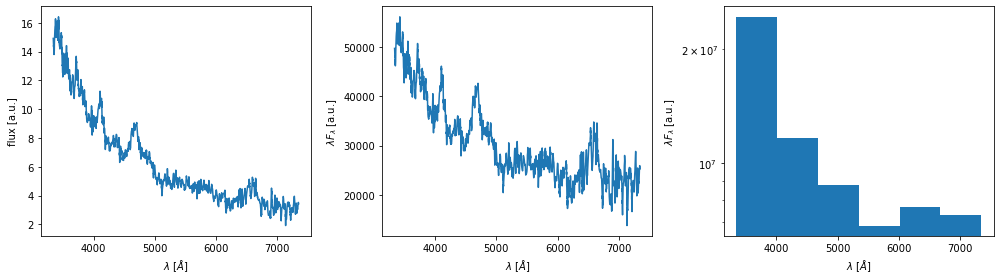

In [34]:
dct0613 = Table.read('DCT_0613.csv', names=['wave', 'flux'])
wave = dct0613['wave']
flux = dct0613['flux']

fig, axes = plt.subplots(1,3, figsize=(14,4), tight_layout=True)

ax = axes[0]
ax.plot(wave, flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='flux [a.u.]');

ax = axes[1]
ax.plot(wave, wave*flux)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

ax = axes[2]
ax.hist(wave, bins=6, weights=wave*flux, log=True)
ax.set(xlabel='$\lambda$ [$\AA$]',
       ylabel='$\lambda F_\lambda$ [a.u.]');

0.9441160796451676
It is a TDE!


<ipython-input-2-1cf1c1ea754b>:4: RuntimeWarning: divide by zero encountered in true_divide
  return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
<ipython-input-2-1cf1c1ea754b>:4: RuntimeWarning: invalid value encountered in true_divide
  return b + (a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


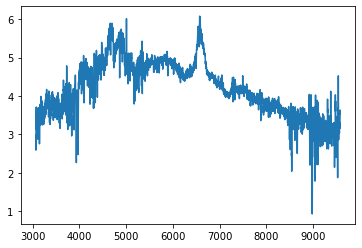

In [3]:
wave = []
flux = []
new_flux = []
restwave = []
file = open('samplePaperTDE.txt', 'r')

prom  = 0
wid = 0
z = 0.043671

for line in file.readlines():
    currentline = line.rstrip().split("")
    wave.append(float(currentline[0]))
    flux.append(float(currentline[1]))
for k in range(len(flux)):
    new_flux.append(flux[k]*math.pow(10.0,16.0))
    restwave.append(wave[k]/(1+z))
smoothed = [gaussian_filter1d(new_flux, 5)]
good_he_peaks = []
good_o_peaks = []
good_h_peaks = []
good_he_widths = []
good_o_widths = []
good_h_widths = []
he_params = []
o_params = []
h_params = []

for k in range(len(smoothed)):
    he_peaks,he_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4670,4700)
    o_peaks,o_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,4992,5022)
    h_peaks,h_widths = has_peak_in_range(restwave,smoothed[k],prom,wid,6540,6570)
    good_he_peaks.extend(he_peaks)
    good_o_peaks.extend(o_peaks)
    good_h_peaks.extend(h_peaks)
    good_he_widths.extend(he_widths)
    good_o_widths.extend(o_widths)
    good_h_widths.extend(h_widths)

for k in range(len(smoothed)):
    for j in range(len(good_he_peaks)):
        he_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_he_peaks[j],good_he_widths[j]))
    for j in range(len(good_o_peaks)):
        o_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_o_peaks[j],good_o_widths[j]))
    for j in range(len(good_h_peaks)):
        h_params.append(fit_gaussian_to_peak(restwave,smoothed[k],good_h_peaks[j],good_h_widths[j]))

if he_params == []:
    pass
elif h_params == []:
    pass
else:
    result = is_TDE(he_params,o_params,h_params)

    if result is True:
        print('It is a TDE!')
plt.plot(restwave,new_flux)

In [4]:
lambda_F = []

for k in range(len(restwave)):
    lambda_F.append(new_flux[k]*restwave[k])


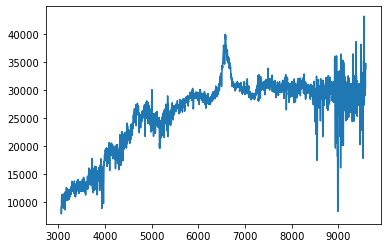

In [10]:

plt.plot(restwave,lambda_F)

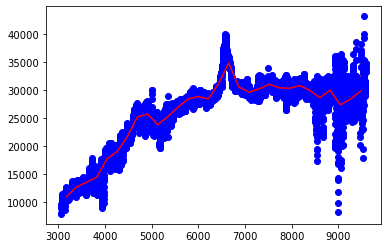

In [17]:
nbins = 30

n, _ = np.histogram(restwave, bins=nbins)
sy, _ = np.histogram(restwave, bins=nbins, weights=lambda_F)
sy2, _ = np.histogram(restwave, bins=nbins, weights=np.multiply(lambda_F,lambda_F))
average = sy/n
std = np.sqrt(sy2/n - average*average)

plt.plot(restwave, lambda_F, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, average, yerr=std, fmt='r-')
plt.show()